# Measuring scintillation arcs with sctintools
In this notebook we will measure some scintillation arcs for PSR J0437-4715 to reproduce the method in Reardon et al. (2019).

## Import modules and load data
First, we import some modules and set the path for our input dynamic spectra

In [1]:
import glob  # for creating a list of files
from dynspec import Dynspec  # The dynamic spectrum class

data_dir = "./J0437-4715"
dyn_files = sorted(glob.glob(data_dir + '/*.dynspec'))

Now let's load and look at the first dynamic spectrum

LOADING ./J0437-4715/p111220_074112.rf.pcm.dynspec...
...LOADED in 0.45 seconds

	 OBSERVATION PROPERTIES

filename:			p111220_074112.rf.pcm.dynspec
MJD:				55915.3202776492
Centre frequency (MHz):		1382.0
Bandwidth (MHz):		400.0
Channel bandwidth (MHz):	0.78125
Integration time (s):		3904.0
Subintegration time (s):	32.0


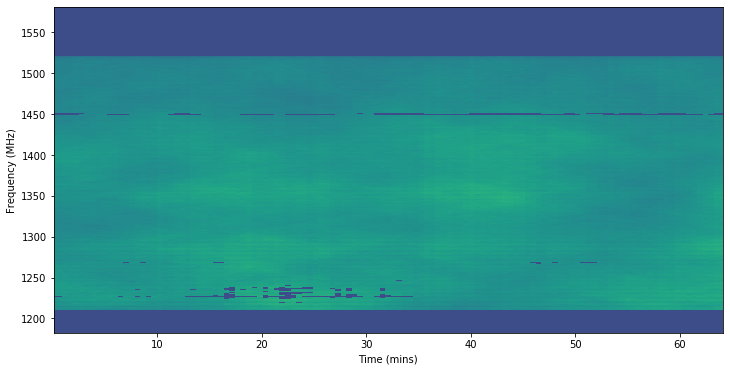

In [2]:
dyn = Dynspec(filename=dyn_files[0], process=False)  # loads the first dynamic spectrum, without processing
dyn.plot_dyn()  # plot the dynamic spectrum

Clearly the dynamic spectrum could use a bit of cleaning up!

## Processing dynamic spectra
The default processing can be accessed with the "process=True" option (True by default) for the Dynspec class, or can be done after initialisation with:

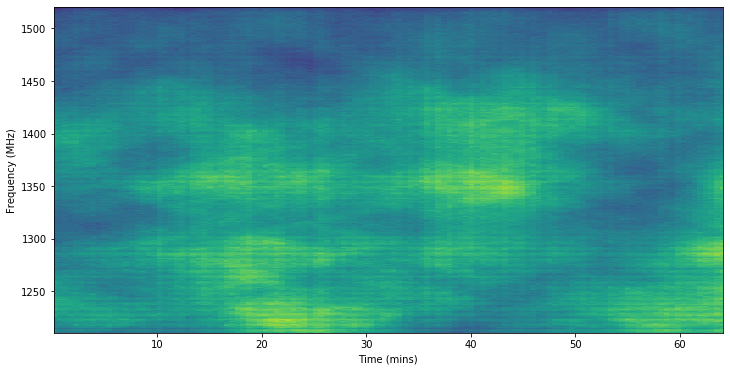

In [3]:
dyn.default_processing()
dyn.plot_dyn()

This processing command executes the following:
    1. dyn.trim_edges()  # to cut off the leading and trailing zeros on the band edges
    2. dyn.refill()  # to refills gaps (from e.g. RFI excision) with the mean flux. linear=True uses linear interp
    3. dyn.calc_acf()  # to calculate the autocovariance function
    4. dyn.calc_sspec()  # to calculate the secondary spectrum
     
Therefore, we can now view the ACF and secondary spectrum!

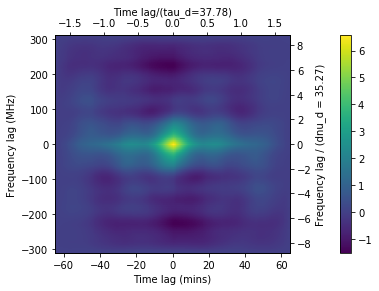

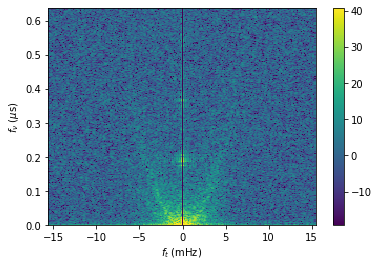

In [4]:
dyn.plot_acf()
dyn.plot_sspec()

For these particular observations it may also help to remove the horizontal and vertical striations from the dynamic spectrum, before re-computing the secondary spectrum. To do this, we can use

    dyn.correct_dyn()  # which uses the svd of the dynamic spectrum
    
And then we re-plot the dynamic spectrum, re-calculate the secondary spectrum, and then plot the secondary spectrum. 


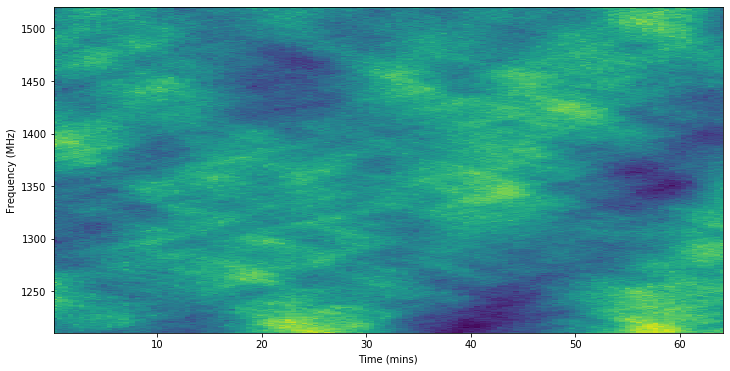

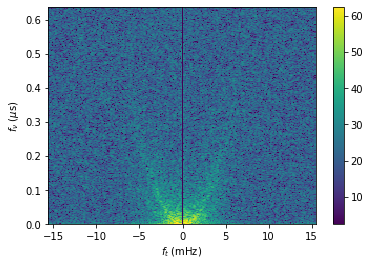

In [5]:
dyn.correct_dyn()
dyn.plot_dyn()
dyn.calc_sspec()
dyn.plot_sspec()  # Or we can save a step by using dyn.calc_sspec(plot=True) in the previous line

## Fitting arcs

Scintillations arcs are actually sharper when the dynamic spectrum is sampled in equal wavelength steps, rather than the traditional frequency steps. Therefore we re-sample the dynamic spectrum in equal "lamsteps" (for "lambda steps"). The scale_dyn() method will do this rescaling by default, and can be accessed from the initialisation of a Dynspec object with the optional flag "lamsteps=True"

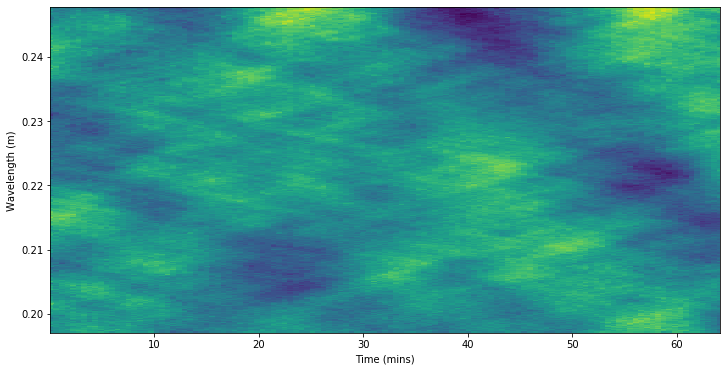

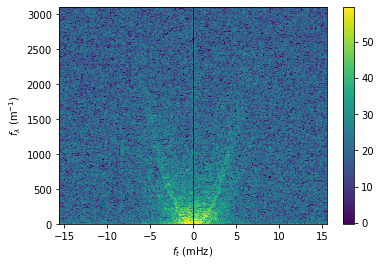

In [6]:
dyn.scale_dyn()
dyn.plot_dyn(lamsteps=True)
dyn.plot_sspec(lamsteps=True)

After resampling, the arc is sharpened slightly and the secondary arc becomes clearer! Now we can fit this arc, and plot the result with:

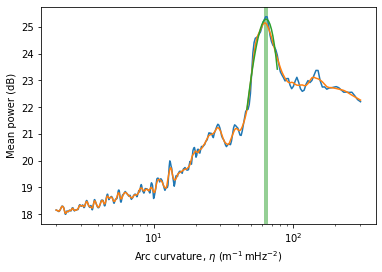

In [20]:
dyn.fit_arc(lamsteps=True, plot=True, etamin=2, etamax=400, numsteps=1e3, nsmooth=7)

After fitting for the arc curvature, if we were to re-plot the secondary spectrum, we will see the arc over-plotted as well as the regions along the axes that were masked for the fit.

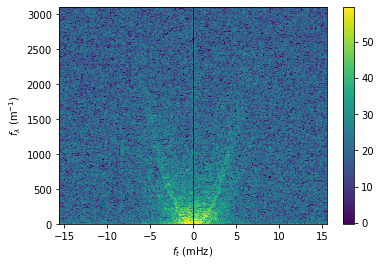

In [8]:
dyn.plot_sspec(lamsteps=True)

## Summing and cropping dynamic spectra

Occasionally we have multiple separate observations of a pulsar separated by a short period of time. In such cases it can be useful to stitch the dynamic spectra in time to increase the total time span and therefore the number of scintles in the dynamic spectrum. This can help with the estimation of scintillation timescale, bandwidth, and increase the Doppler Frequency resolution in the secondary spectrum!

To stitch multiple observations, it is as simple as loading the observations as separate Dynspec objects and then adding them with "+". As shown below, where we load and sum each dynamic spectrum in the example data directory:

In [13]:
dyn_tot = Dynspec(filename=dyn_files[0], verbose=False)  # load first observation and do default processing
dyn_tot.correct_dyn()  # we are interested in the secondary spectrum, not acf, so this is okay
for dyn_file in dyn_files[1::]:
    dyn_new = Dynspec(filename=dyn_file, verbose=False)  # add every remaining observation
    dyn_new.correct_dyn()
    dyn_new.refill()
    dyn_tot += dyn_new

Now adding p111220_084944.rf.pcm.dynspec ...
Now adding p111220_095816.rf.pcm.dynspec ...
Now adding p111220_110656.rf.pcm.dynspec ...
Now adding p111220_121536.rf.pcm.dynspec ...
Now adding p111220_132416.rf.pcm.dynspec ...
Now adding p111220_143248.rf.pcm.dynspec ...
Now adding p111220_154120.rf.pcm.dynspec ...


Now we will plot the dynamic spectrum, and do some further processing in the same way as the individual observation above, ending with a new secondary spectrum.

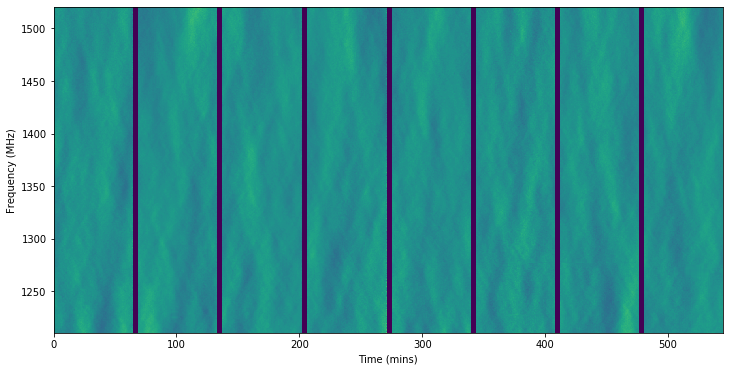

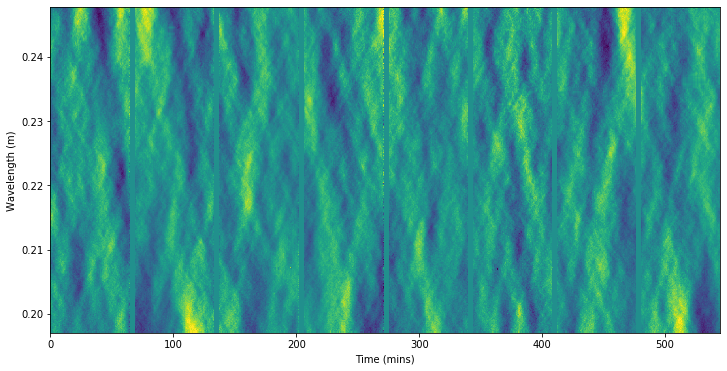

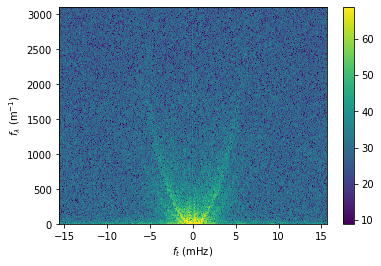

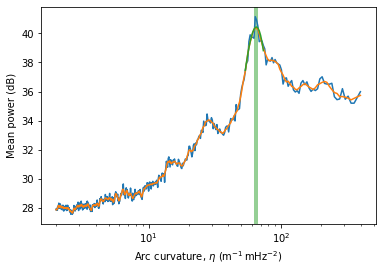

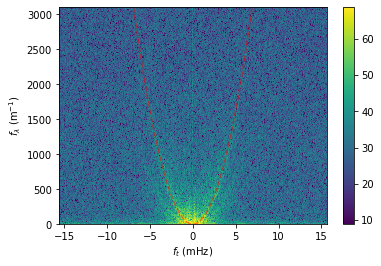

In [14]:
# Plot the dynamic spectrum
dyn_tot.plot_dyn()
dyn_tot.refill(linear=False)  # refill just with the mean
dyn_tot.correct_dyn()
# Plot the refilled, and normalised dynamic spectrum
dyn_tot.plot_dyn(lamsteps=True)
# Plot the secondary spectrum
dyn_tot.calc_sspec(plot=True, lamsteps=True)
# Fit the arc
dyn_tot.fit_arc(etamin=2, etamax=400, plot=True, lamsteps=True, cutmid=3, numsteps=1e3, nsmooth=5, delmax=0.3)  # this function has lots of parameters to tune the fit if needed
# Plot the fitted arc on the secondary spectrum
dyn_tot.plot_sspec(lamsteps=True, plotarc=True)


We can now also "normalise" the secondary spectrum with respect to this curvature. The arc measurement, for a wavelength-resampled spectrum is stored as "betaeta". 

In [15]:
print("Curvature measurement:", round(dyn_tot.betaeta, 1))
print("Curvature uncertainty:", round(dyn_tot.betaetaerr, 1))

Curvature measurement: 64.9
Curvature uncertainty: 2.1


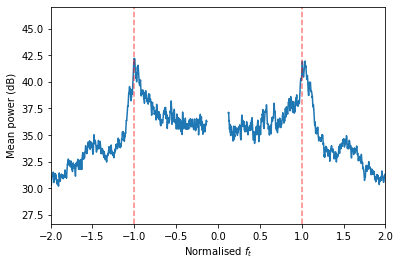

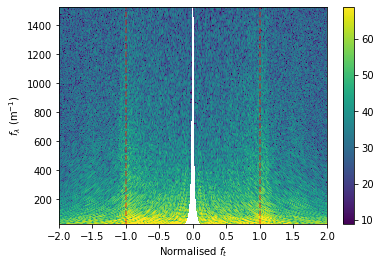

In [16]:
dyn_tot.norm_sspec(lamsteps=True, plot=True, delmax=0.3, cutmid=23, startbin=5)